## Proyecto 2: Redes neuronales
Daniela Gil y Sofia Ochoa


El objetivo del proyecto es usar una red neuronal para clasificar datos sobre señales de voz, de acuerdo al sentimiento de dicha voz: enojado, triste, feliz.

 Primero importamos las librerias necesarias

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

Importamos como dataframe de pandas al excel que contiene los datos sobre las señales de voz

In [ ]:
df=pd.read_csv('emotions_by_voice registers.csv')

In [ ]:
df

,Unnamed: 0.1,Unnamed: 0,X,meanfreq,sd,median,Q25,Q75,IQR,skew,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0,1,1,0.181338,0.060495,0.187476,0.126197,0.233586,0.107389,0.869088,...,0.181338,0.137742,0.023022,0.271186,0.777344,0.085938,6.226562,6.140625,0.116586,sad
1,1,2,2,0.186897,0.062260,0.195070,0.130847,0.243987,0.113140,1.191767,...,0.186897,0.121811,0.018412,0.271186,0.930339,0.085938,4.000000,3.914062,0.144983,sad
2,2,3,3,0.189102,0.062901,0.204945,0.131422,0.249978,0.118556,1.312690,...,0.189102,0.123758,0.083333,0.262295,0.332386,0.085938,0.625000,0.539062,0.334783,sad
3,4,5,5,0.183036,0.060051,0.174115,0.129949,0.236967,0.107017,1.096409,...,0.183036,0.128469,0.044693,0.258065,1.012019,0.085938,5.468750,5.382812,0.304910,sad
4,5,6,6,0.168793,0.057910,0.156266,0.116783,0.216326,0.099543,1.386837,...,0.168793,0.109720,0.022472,0.235294,0.228795,0.093750,0.750000,0.656250,0.306777,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,1243,1244,1436,0.244013,0.035477,0.254385,0.229653,0.265573,0.035920,2.214752,...,0.244013,0.202433,0.028829,0.271186,0.616536,0.210938,1.609375,1.398438,0.281869,happy
905,1244,1245,1437,0.235383,0.045303,0.248974,0.220745,0.264233,0.043488,2.474743,...,0.235383,0.189293,0.031250,0.275862,1.115723,0.265625,5.500000,5.234375,0.167861,happy
906,1245,1246,1438,0.231211,0.044793,0.234847,0.221477,0.262090,0.040613,2.607668,...,0.231211,0.171805,0.022346,0.275862,1.070801,0.265625,4.554688,4.289062,0.214936,happy
907,1246,1247,1439,0.213587,0.082267,0.249435,0.207680,0.268538,0.060858,3.460579,...,0.213587,0.155277,0.020592,0.275862,1.724888,0.273438,6.812500,6.539062,0.238857,happy


El dataset cotiene unicamente datos de tipo númerico que representan parámetros estadísticos que describen la frecuencia de las señales de voz como lo son la media, la desviación estandar, el rango intercuartilico, etc.

Las posibles emociones que describen la señal de voz son 3 (enojado,triste y feliz), las cuales correponden a las 3 categorías de nuestra variable objetivo llamada **label**.

En este caso, como varios de los atributos son parámetros estadísticos entonces no hace falta normalizar las columnas.

Se eliminan las columnas de tipo índice que no aportan información

In [ ]:
df = df.drop(columns= ['Unnamed: 0', 'X', 'Unnamed: 0.1'])

Creamos los dummies de la variable objetivo, **label**, ya que es una variable categorica, y se convierte cada valor de la celda en una columna diferente de tipo númerica

In [ ]:
df = pd.get_dummies(df, 'label')

In [ ]:
df

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label_angry,label_happy,label_sad
0,0.181338,0.060495,0.187476,0.126197,0.233586,0.107389,0.869088,2.863717,0.923566,0.307220,...,0.023022,0.271186,0.777344,0.085938,6.226562,6.140625,0.116586,0,0,1
1,0.186897,0.062260,0.195070,0.130847,0.243987,0.113140,1.191767,3.878650,0.918848,0.298859,...,0.018412,0.271186,0.930339,0.085938,4.000000,3.914062,0.144983,0,0,1
2,0.189102,0.062901,0.204945,0.131422,0.249978,0.118556,1.312690,4.589995,0.919519,0.313069,...,0.083333,0.262295,0.332386,0.085938,0.625000,0.539062,0.334783,0,0,1
3,0.183036,0.060051,0.174115,0.129949,0.236967,0.107017,1.096409,3.680995,0.921361,0.329295,...,0.044693,0.258065,1.012019,0.085938,5.468750,5.382812,0.304910,0,0,1
4,0.168793,0.057910,0.156266,0.116783,0.216326,0.099543,1.386837,5.031744,0.926238,0.337047,...,0.022472,0.235294,0.228795,0.093750,0.750000,0.656250,0.306777,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,0.244013,0.035477,0.254385,0.229653,0.265573,0.035920,2.214752,7.565052,0.821874,0.136933,...,0.028829,0.271186,0.616536,0.210938,1.609375,1.398438,0.281869,0,1,0
905,0.235383,0.045303,0.248974,0.220745,0.264233,0.043488,2.474743,9.959019,0.848109,0.236957,...,0.031250,0.275862,1.115723,0.265625,5.500000,5.234375,0.167861,0,1,0
906,0.231211,0.044793,0.234847,0.221477,0.262090,0.040613,2.607668,10.698821,0.848702,0.241998,...,0.022346,0.275862,1.070801,0.265625,4.554688,4.289062,0.214936,0,1,0
907,0.213587,0.082267,0.249435,0.207680,0.268538,0.060858,3.460579,18.034614,0.882544,0.425394,...,0.020592,0.275862,1.724888,0.273438,6.812500,6.539062,0.238857,0,1,0


Creamos los conjuntos de entrenamiento (60%), validación (20%) y test (20%)

In [ ]:
test= df[546:726]
val= df[726:]
train= df[:546]

Ahora definimos la clase 'MyDataset' para convertir los datos de los atributos y la variable objetivo a parejas ordenadas de tensores y así alimentar la red neuronal

In [ ]:
class MyDataset():

  def __init__(self, df, target_columns):
    y = df.iloc[:, target_columns].values
    X = df.drop(columns=df.columns[target_columns]).values
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


A continuación hacemos uso de la clase MyDataset para convertir cada conjunto definido anteriormente a tensores. En este caso, le mandamos como atributos el respectivo conjunto y la variable objetivo que se subdivide en tres columnas, una por cada categoría

In [ ]:
train_sec=MyDataset(train,[20, 21, 22])
test_sec=MyDataset(test,[20, 21, 22])
val_sec=MyDataset(val,[20, 21, 22])

Ahora definimos los dataloaders para procesar los datos y alimentar a la red neuronal por lotes. Lo hicimos con batch_size = 3

In [ ]:
train_data=DataLoader(
    train_sec,
    batch_size=3,
    shuffle=False,
 )

test_data=DataLoader(
    test_sec,
    batch_size=3,
    shuffle=False,
 )

val_data=DataLoader(
    val_sec,
    batch_size=3,
    shuffle=False,
 )

Se crea la clase Net que define la arquitectura de la red neuronal. Tiene una sola capa oculta con 30 nodos y como función de activación se usó la función sigmoide.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 30)
        self.fc2 = nn.Linear(30, 3)

    def forward(self, x):
    	# Do the forward pass
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

Se define el modelo, el optimizador y la función de costo. Se usó un learning rate de 0.1. Como función de costo se usó CrossEntropyLoss ya que es un problema de clasificación y se adapta mejor a este tipo de problemas.

In [ ]:
model=Net()
optimizer=torch.optim.SGD(model.parameters(), lr=0.1)
criterion=nn.CrossEntropyLoss()

# Train con 100 epochs

Se define la función para entrenar la red:

In [ ]:
def train_model(model,optimizer,loss_module,train_loader,valid_loader,num_epochs):

  valid_loss_min =np.inf  #vamos a encontrar el menor valor de error de validación. Por eso la inicializmaos como 'infinito'

  for i in range(num_epochs):
    model.train()  #ponemos el modelo en modo entrenamiento
    train_loss = 0.0
    v_loss = 0.0

    for data, target in train_loader:
        # se reinician los gradientes
        optimizer.zero_grad()
        # forward pass: calcular la salida para los datos de entrada..
        preds = model(data)
        #print(preds)
        preds = preds.squeeze(dim=1)
        # calculate the batch loss
        loss = loss_module(preds, target)
        # backpropagation: cálculo de gradientes
        loss.backward()
        # actualizar los parámetros
        optimizer.step()
        # actualizar la cuenta de costos a lo largo de los lotes
        train_loss += loss.item()*data.size(0)
    # for data,labels in testloader:
    train_loss = train_loss/len(train_loader.dataset)
    print('train_loss:')
    print(train_loss)

    model.eval() #Ponemos el modelo en modo evaluación.
    #for param in model.parameters():
    #  print(param.data)
    # vamos a evaluar el modelo entrenado, calculando predicciones con el conjunto de validación
    for data,target in valid_loader:
        output=model(data)
        valid_loss= loss_module(output, target)
        valid_loss += loss.item()*data.size(0)
    valid_loss = valid_loss/len(valid_loader.dataset)
    #imprimir estadísticas de entrenamiento y validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i, train_loss, valid_loss))


    #Guardamos el modelo con el menor error de validación.
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'proyecto100epoch.pt')
        valid_loss_min = valid_loss

Ahora se entrena la red con 100 epochs y se imprime el Training Loss y el Validation Loss.

In [ ]:
train_model(model,optimizer,criterion,train_data,val_data, 100)

train_loss:
1.1496632744322766
Epoch: 0 	Training Loss: 1.149663 	Validation Loss: 0.024657
Validation loss decreased (inf --> 0.024657).  Saving model ...
train_loss:
1.1110562285879155
Epoch: 1 	Training Loss: 1.111056 	Validation Loss: 0.024998
train_loss:
1.103484386598671
Epoch: 2 	Training Loss: 1.103484 	Validation Loss: 0.025310
train_loss:
1.1001260395233448
Epoch: 3 	Training Loss: 1.100126 	Validation Loss: 0.025466
train_loss:
1.0983448251263126
Epoch: 4 	Training Loss: 1.098345 	Validation Loss: 0.025522
train_loss:
1.0972594625347263
Epoch: 5 	Training Loss: 1.097259 	Validation Loss: 0.025537
train_loss:
1.0965345187501594
Epoch: 6 	Training Loss: 1.096535 	Validation Loss: 0.025537
train_loss:
1.0960215814821013
Epoch: 7 	Training Loss: 1.096022 	Validation Loss: 0.025534
train_loss:
1.0956444917144357
Epoch: 8 	Training Loss: 1.095644 	Validation Loss: 0.025531
train_loss:
1.0953544466705112
Epoch: 9 	Training Loss: 1.095354 	Validation Loss: 0.025527
train_loss:
1.095

Ahora, se imprimen los parámetros del mejor modelo

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

fc1.weight tensor([[ 6.1187e-02,  1.6123e-01, -1.6564e-01, -1.2114e-01, -1.6905e-01,
         -2.1478e-01,  9.1257e-02, -3.4172e-01,  7.6409e-02, -4.0329e-01,
          2.4411e-02,  1.7701e-02, -8.7576e-02, -2.3700e-01, -8.9269e-02,
         -4.1935e-02,  1.1632e-01, -3.1349e-01, -5.3395e-02, -9.9308e-02],
        [-1.7141e-01, -1.9082e-01,  2.2348e-01, -6.8932e-02, -6.8689e-02,
          8.5449e-02, -1.4671e-01, -3.5028e-01,  1.3734e-01, -1.1140e-01,
          1.9466e-01,  2.6242e-02,  2.1890e-01, -1.3478e-01,  1.2893e-01,
         -2.4178e-01, -1.6706e-01, -2.5666e-01, -2.4467e-02, -7.5713e-02],
        [-5.7343e-03, -1.0757e-01, -2.0510e-01, -2.2446e-01, -5.2248e-02,
          1.5052e-01, -2.7757e-01, -1.1237e-02,  6.6789e-04, -4.7797e-02,
          6.3233e-04,  7.5951e-02, -2.1941e-01, -2.1115e-01,  9.0904e-02,
         -4.5474e-01,  9.0440e-02, -7.8209e-01, -9.6474e-01, -1.2026e-01],
        [ 4.8604e-02, -7.8192e-02, -1.3993e-01,  1.6485e-04, -6.9792e-02,
          1.5429e-02,  4

Se imprime el test_loss del mejor modelo

In [ ]:
test_loss=0.0

criterion= nn.CrossEntropyLoss()
for data, target in test_data:
  output=model(data)
  loss= criterion(output,target)
  test_loss += loss.item()*data.size(0)
test_loss = test_loss/len(test_data.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 1.071757



Por último, se evalua el desempeño del modelo mediante la métrica accuracy. Se van a tomar 400 valores aleatorios de todo el dataset  y se calcula la métrica dividiendo el número de predicciones correctas sobre 400.

In [ ]:
data_sec=MyDataset(df,[20, 21, 22])

In [ ]:
num_total_predictions=400
num_predicciones_correctas=0
for i in range(num_total_predictions):
  i = random.randrange(1, 905)
  tensor_prediccion = data_sec[i][1]
  tensor_columnas= data_sec[i][0]
  model.eval()
  with torch.no_grad():
    tensor_modelo = model(tensor_columnas)
  if np.argmax(tensor_prediccion)== np.argmax(tensor_modelo):
    num_predicciones_correctas+=1

print("Las predicciones que estan bien son:", num_predicciones_correctas)
print("Total predicciones:", num_total_predictions)
print("Accuracy:", num_predicciones_correctas/num_total_predictions)

Las predicciones que estan bien son: 153
Total predicciones: 400
Accuracy: 0.3825


Se elige un registro del dataset de manera aleatoria y se usa el modelo para predecir el sentimiento.

In [ ]:
registro = random.randrange(1,905)
tensor_prediccion = data_sec[registro][1]
tensor_columnas= data_sec[registro][0]
model.eval()
with torch.no_grad():
    tensor_modelo = model(tensor_columnas)

print(tensor_prediccion)
print(tensor_modelo)

tensor([0., 1., 0.])
tensor([ 0.1475, -0.2506, -0.0014])


Como se ve, la predicción no es correcta, ya que el modelo predice que el sentimiento es angry pero en realidad es happy.

# Variación de hiperparámetros para encontrar el mejor modelo
En esta sección, vamos a variar los hiperparámetros y comparar como cambia el modelo al modificar estos atributos.

Primero, el número de epoch para entrenar el modelo

In [ ]:
epochs = [100, 500, 1000, 1500, 2000, 4000, 6000]
loss_test = []
for e in epochs:
  print('Numero de epochs:', e)
  model=Net()
  train_model(model,optimizer,criterion,train_data,val_data, e)
  print('---------------------------------------------')
  test_loss=0.0
  for data, target in test_data:
    output=model(data)
    loss= criterion(output,target)
    test_loss += loss.item()*data.size(0)
  test_loss = test_loss/len(test_data.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))
  loss_test.append(format(test_loss))
  print('---------------------------------------------')

Se han truncado las últimas 5000 líneas del flujo de salida.
train_loss:
1.105289571232848
Epoch: 4751 	Training Loss: 1.105290 	Validation Loss: 0.020594
Validation loss decreased (0.020594 --> 0.020594).  Saving model ...
train_loss:
1.105289571232848
Epoch: 4752 	Training Loss: 1.105290 	Validation Loss: 0.020594
Validation loss decreased (0.020594 --> 0.020594).  Saving model ...
train_loss:
1.105289571232848
Epoch: 4753 	Training Loss: 1.105290 	Validation Loss: 0.020594
Validation loss decreased (0.020594 --> 0.020594).  Saving model ...
train_loss:
1.105289571232848
Epoch: 4754 	Training Loss: 1.105290 	Validation Loss: 0.020594
Validation loss decreased (0.020594 --> 0.020594).  Saving model ...
train_loss:
1.105289571232848
Epoch: 4755 	Training Loss: 1.105290 	Validation Loss: 0.020594
Validation loss decreased (0.020594 --> 0.020594).  Saving model ...
train_loss:
1.105289571232848
Epoch: 4756 	Training Loss: 1.105290 	Validation Loss: 0.020594
Validation loss decreased (0.0

Se redondea el loss_test para graficar

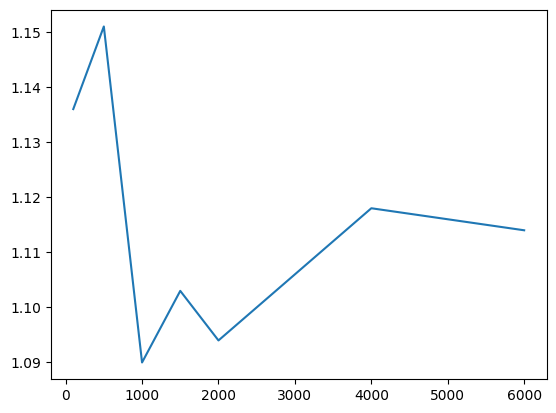

In [ ]:
lt = []
for i in loss_test:
  redon= round(float(i),3)
  lt.append(redon)
plt.plot(epochs,lt)
plt.show()

Ahora, se varia el learning rate del optimizador para ver como cambia respecto al test loss

In [ ]:
lr = [0.001, 0.01, 0.1, 1, 5]
loss_test = []
for e in lr:
  print('Learning rate:', e)
  model=Net()
  optimizer=torch.optim.SGD(model.parameters(), lr=e)
  train_model(model,optimizer,criterion,train_data,val_data, 1000)
  print('---------------------------------------------')
  test_loss=0.0
  for data, target in test_data:
    output=model(data)
    loss= criterion(output,target)
    test_loss += loss.item()*data.size(0)
  test_loss = test_loss/len(test_data.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))
  loss_test.append(format(test_loss))
  print('---------------------------------------------')

Se han truncado las últimas 5000 líneas del flujo de salida.
1.1570899176510263
Epoch: 394 	Training Loss: 1.157090 	Validation Loss: 0.027550
Validation loss decreased (0.027553 --> 0.027550).  Saving model ...
train_loss:
1.1570602166347015
Epoch: 395 	Training Loss: 1.157060 	Validation Loss: 0.027547
Validation loss decreased (0.027550 --> 0.027547).  Saving model ...
train_loss:
1.1570305867946191
Epoch: 396 	Training Loss: 1.157031 	Validation Loss: 0.027544
Validation loss decreased (0.027547 --> 0.027544).  Saving model ...
train_loss:
1.1570009600111852
Epoch: 397 	Training Loss: 1.157001 	Validation Loss: 0.027541
Validation loss decreased (0.027544 --> 0.027541).  Saving model ...
train_loss:
1.1569714528737052
Epoch: 398 	Training Loss: 1.156971 	Validation Loss: 0.027539
Validation loss decreased (0.027541 --> 0.027539).  Saving model ...
train_loss:
1.1569420304490534
Epoch: 399 	Training Loss: 1.156942 	Validation Loss: 0.027536
Validation loss decreased (0.027539 --> 0.

De igual manera se aproximan los valores para graficar

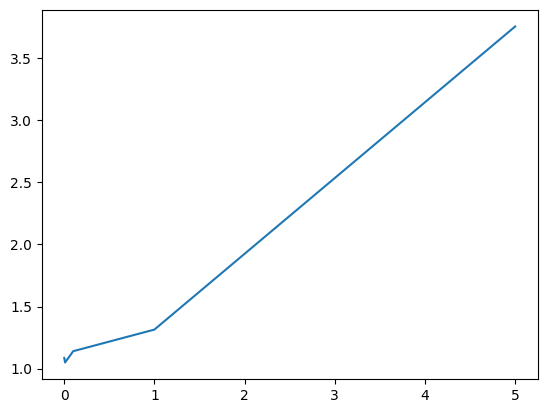

In [ ]:
lt = []
for i in loss_test:
  redon= round(float(i),3)
  lt.append(redon)
plt.plot(lr,lt)
plt.show()

De ambas gráficas se puede concluir que se va a tener un menor test loss con un learning rate pequeño y con 1000 epochs. Ahora entrenemos la red de esa manera para ver cuanto cambia el accuracy.

In [ ]:
model=Net()
optimizer=torch.optim.SGD(model.parameters(), lr=0.01)
train_model(model,optimizer,criterion,train_data,val_data, 1000)

train_loss:
1.124303156202966
Epoch: 0 	Training Loss: 1.124303 	Validation Loss: 0.024352
Validation loss decreased (inf --> 0.024352).  Saving model ...
train_loss:
1.1136695654182645
Epoch: 1 	Training Loss: 1.113670 	Validation Loss: 0.024317
Validation loss decreased (0.024352 --> 0.024317).  Saving model ...
train_loss:
1.1088750070922977
Epoch: 2 	Training Loss: 1.108875 	Validation Loss: 0.024301
Validation loss decreased (0.024317 --> 0.024301).  Saving model ...
train_loss:
1.1046901109454397
Epoch: 3 	Training Loss: 1.104690 	Validation Loss: 0.024296
Validation loss decreased (0.024301 --> 0.024296).  Saving model ...
train_loss:
1.101008448626969
Epoch: 4 	Training Loss: 1.101008 	Validation Loss: 0.024304
train_loss:
1.097786953488549
Epoch: 5 	Training Loss: 1.097787 	Validation Loss: 0.024321
train_loss:
1.0950001016422943
Epoch: 6 	Training Loss: 1.095000 	Validation Loss: 0.024345
train_loss:
1.0926191007697976
Epoch: 7 	Training Loss: 1.092619 	Validation Loss: 0.024

In [ ]:
data_sec=MyDataset(df,[20, 21, 22])

In [ ]:
num_total_predictions=400
num_predicciones_correctas=0
for i in range(num_total_predictions):
  i = random.randrange(1, 905)
  tensor_prediccion = data_sec[i][1]
  tensor_columnas= data_sec[i][0]
  model.eval()
  with torch.no_grad():
    tensor_modelo = model(tensor_columnas)
  if np.argmax(tensor_prediccion)== np.argmax(tensor_modelo):
    num_predicciones_correctas+=1

print("Las predicciones que estan bien son:", num_predicciones_correctas)
print("Total predicciones:", num_total_predictions)
print("Accuracy:", num_predicciones_correctas/num_total_predictions)

Las predicciones que estan bien son: 187
Total predicciones: 400
Accuracy: 0.4675


Como se ve, aumentó el score de accuracy, por lo que este es un modelo más preciso para clasificar los datos.

In [ ]:
registro = random.randrange(1,905)
tensor_prediccion = data_sec[registro][1]
tensor_columnas= data_sec[registro][0]
model.eval()
with torch.no_grad():
    tensor_modelo = model(tensor_columnas)

print(tensor_prediccion)
print(tensor_modelo)

tensor([0., 0., 1.])
tensor([-0.0545, -0.3442,  0.0089])


Y con una muestra aleatoria, si predijo bien la emoción, sad

# Conclusiones

En cuanto al desempeño del modelo se obtuvo que al experimentar con distintos valores de los parámetros como el learning rate y número de epochs  el modelo se obtienen distintos resultados y la precisión del modelo varía dependiendo de estos valores. Con los diferentes modelos que hicimos, aunque teniamos un test loss no tan alto, no tenemos un acuraccy muy bueno, y en general se puede afirmar que los modelos no son tan buenos para este dataset, y esto se puede deber a los hiperparametros que les pusimos, batch_size, learning rate, las proporciones del train, test y validation, numero de epochs, que pueden no ser los optimos para que no se sobreajuste pero al mismo tiempo prediga bien los datos. Y tambien puede ser por los pocos datos que se tienen, que tengan un patron especifico que la red no pudo entender.
A medida que usabamos mas epoch, el tiempo se aumentaba, por eso no lo hicimos con tantas, pero puede que con mayor numero se obtenga un mejor accuracy, pero al hacer esto se corre el riesgo de sobreajustar el modelo a los datos de entrenamiento y validacion. Es importante aclarar que el test loss y el accuracy son medidas de desempeño diferente, y aunque con muchas epoch se tiene un menor test loss, esto no implica un mayor accuracy, asi que podria evaluarse con mayor numero y obtener un mejor modelo. Con un learning rate alto el modelo aprende patrones especificos de los datos de entrenamiento, por lo que al evaluarlo con el test loss, se obtiene un mayor puntaje.
Se podrian considerar otras medidas de desempeño, como el F1 score, para evaluar los modelos en futuros proyectos.